<a href="https://colab.research.google.com/github/jordisc97/team9_boehringer/blob/main/Boeringher_team9_Regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

In [44]:
import lightgbm as lgb
from sklearn.metrics import recall_score

# Custom recall metric for LightGBM to penalize False Negatives
def custom_recall_metric(y_true, y_pred):
    """
    Custom recall metric for LightGBM to penalize False Negatives.
    """
    preds_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
    recall = recall_score(y_true, preds_binary)
    return 'recall', recall, True  # True means higher is better (maximize recall)


# Boehringer hackathon 2024

## Read data

In [45]:
# to run locally
path = 'full_train_with_oof.csv'
df = pd.read_csv(path, sep=",")

In [46]:
# Modify the URL to access the raw content of the CSV file
# url = 'https://raw.githubusercontent.com/jordisc97/team9_boehringer/main/train_notebooks/full_train_with_oof.csv'
# df = pd.read_csv(url, sep=",")

# Make a copy of the df
df_hack = df.copy()
display(df)

,Patient,ImagePath,Label,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121
0,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,-4,2315.0,Male,Ex-smoker,2315.0,0.0,0.984993,0.69746,0.442795
1,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,5,2214.0,Male,Ex-smoker,2315.0,9.0,0.984993,0.69746,0.442795
2,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,7,2061.0,Male,Ex-smoker,2315.0,11.0,0.984993,0.69746,0.442795
3,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,9,2144.0,Male,Ex-smoker,2315.0,13.0,0.984993,0.69746,0.442795
4,ID00007637202177411956430,./preprocessed_images/ID0000763720217741195643...,1,79.0,11,2069.0,Male,Ex-smoker,2315.0,15.0,0.984993,0.69746,0.442795
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1564,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,31,2908.0,Male,Never smoked,NaN,31.0,0.800631,0.12026,0.400990
1565,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,43,2975.0,Male,Never smoked,2925.0,43.0,0.800631,0.12026,0.400990
1566,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,43,2975.0,Male,Never smoked,NaN,43.0,0.800631,0.12026,0.400990
1567,ID00426637202313170790466,./preprocessed_images/ID0042663720231317079046...,1,73.0,59,2774.0,Male,Never smoked,2925.0,59.0,0.800631,0.12026,0.400990


## Feature Engineering
+ Adding max_FVC
+ Encode the categorical values
+ Drop unwanted columns
+ Groupby the last row per patient

In [47]:
# Adding max_FVC and max_FVC
df_hack['max_FVC'] = df_hack.groupby('Patient')['FVC'].transform('max')
df_hack['min_FVC'] = df_hack.groupby('Patient')['FVC'].transform('min')

In [48]:
# Encode Sex and SmokingStatus
df_hack['Sex'] = df_hack['Sex'].map({'Male': 1, 'Female': 2})
df_hack['SmokingStatus'] = df_hack['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 2,  'Currently smokes': 5})

In [49]:
# Encode Parient
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'Category' column
df_hack['Patient_encoded'] = le.fit_transform(df_hack['Patient'])

In [50]:
# Drop Image Path
df_hack = df_hack.drop(columns=['ImagePath'])

In [51]:
# Groupby the last row per patient
df_hack = df_hack.groupby('Patient').tail(1)

In [52]:
display(df_hack)

,Patient,Label,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,max_FVC,Patient_encoded
8,ID00007637202177411956430,1,79.0,57,2057.0,1,2,2000.0,61.0,0.984993,0.697460,0.442795,2315.0,0
17,ID00009637202177434476278,0,69.0,60,3214.0,1,2,3214.0,52.0,0.026978,0.028545,0.021995,3895.0,1
26,ID00010637202177584971671,1,60.0,54,2518.0,1,2,2474.0,54.0,0.546172,0.039994,0.663621,3523.0,2
35,ID00012637202177665765362,0,65.0,87,2971.0,1,0,2971.0,54.0,0.011009,0.730236,0.832549,3759.0,3
44,ID00014637202177757139317,0,56.0,54,3027.0,1,2,3027.0,54.0,0.995485,0.204855,0.991042,3897.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,ID00419637202311204720264,1,73.0,59,2727.0,1,2,2694.0,53.0,0.045938,0.025572,0.000750,3020.0,170
1516,ID00421637202311550012437,0,68.0,54,2771.0,1,2,2716.0,39.0,0.003108,0.030378,0.013660,2853.0,171
1532,ID00422637202311677017371,1,73.0,47,1713.0,1,2,1713.0,41.0,0.986988,0.591483,0.175123,1955.0,172
1550,ID00423637202312137826377,1,72.0,70,2578.0,1,2,2432.0,53.0,0.182871,0.057135,0.514883,3294.0,173


## Model Training
+ Split train and test
+ Cutom loss function to minimize False Negatives

### Results:
+ No image predictions: Recall Score: 0.9032258064516129
+ With image predictions: 0.967741935483871

In [53]:
# Generate the target and X_training
y = df_hack['Label']
X = df_hack.drop(columns=['Patient','Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

- Testing if image predictions are important:

In [54]:
# # Generate the target and X_training
# y = df_hack['Label']

# to_drop = ['Patient', 'Label', 'OOF_resnet34', 'OOF_squeezenet1_0', 'OOF_densenet121']
# X = df_hack.drop(columns=to_drop)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
# Adjust LightGBM parameters to include weighted loss
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'random_state': 42,
    'scale_pos_weight': 2.0,  # Increase weight for the positive class
}

# Prepare dataset for training
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Initialize the LGBMClassifier model
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    scale_pos_weight=2.0,
    metric='binary_logloss'
)

# Fit the model
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric=custom_recall_metric,
              )

[LightGBM] [Info] Number of positive: 61, number of negative: 61
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 122, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

LGBMClassifier(metric='binary_logloss', objective='binary', random_state=42,
               scale_pos_weight=2.0)

In [56]:
# Make predictions
y_pred = lgb_model.predict(X_test)

# Calculate recall score
recall = recall_score(y_test, y_pred)
print(f"Recall Score: {recall}")

Recall Score: 0.967741935483871


In [57]:
# Make predictions for both train and test sets
y_train_pred = lgb_model.predict_proba(X)[:, 1]  # Get probabilities for the positive class

# Add forecast back to the dataframe
X['prob_IPF'] = y_train_pred

# Revert the Patient_encoded encoding
X['Patient'] = le.inverse_transform(X['Patient_encoded'])

# Drop the Patient_encoded column
X = X.drop(columns=['Patient_encoded'])

display(X)

,Age,Weeks,FVC,Sex,SmokingStatus,min_FVC,base_week,OOF_resnet34,OOF_squeezenet1_0,OOF_densenet121,max_FVC,prob_IPF,Patient
8,79.0,57,2057.0,1,2,2000.0,61.0,0.984993,0.697460,0.442795,2315.0,0.945899,ID00007637202177411956430
17,69.0,60,3214.0,1,2,3214.0,52.0,0.026978,0.028545,0.021995,3895.0,0.052668,ID00009637202177434476278
26,60.0,54,2518.0,1,2,2474.0,54.0,0.546172,0.039994,0.663621,3523.0,0.961229,ID00010637202177584971671
35,65.0,87,2971.0,1,0,2971.0,54.0,0.011009,0.730236,0.832549,3759.0,0.010398,ID00012637202177665765362
44,56.0,54,3027.0,1,2,3027.0,54.0,0.995485,0.204855,0.991042,3897.0,0.036824,ID00014637202177757139317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,73.0,59,2727.0,1,2,2694.0,53.0,0.045938,0.025572,0.000750,3020.0,0.867628,ID00419637202311204720264
1516,68.0,54,2771.0,1,2,2716.0,39.0,0.003108,0.030378,0.013660,2853.0,0.198962,ID00421637202311550012437
1532,73.0,47,1713.0,1,2,1713.0,41.0,0.986988,0.591483,0.175123,1955.0,0.944366,ID00422637202311677017371
1550,72.0,70,2578.0,1,2,2432.0,53.0,0.182871,0.057135,0.514883,3294.0,0.969911,ID00423637202312137826377


In [58]:
# from google.colab import files

# X.to_csv('LGBM_forecast.csv')
# files.download('LGBM_forecast.csv')

# Model Explainability

/home/ezemriv/anaconda3/envs/ds_312/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


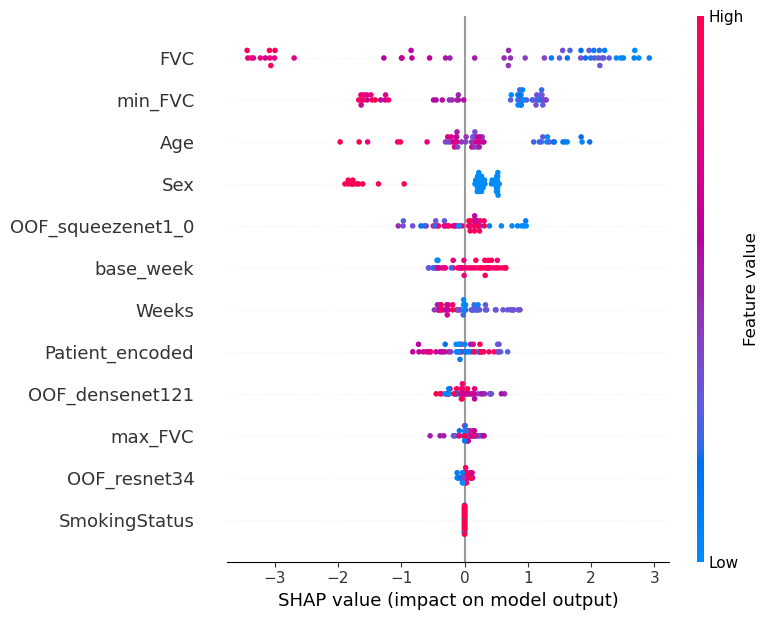

In [59]:
import shap

# Use TreeExplainer for LightGBM model
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=False)